## Import Library

In [32]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [33]:
# !pip install transformers

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import glob
import shutil
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import get_cosine_schedule_with_warmup
from transformers import SegformerForSemanticSegmentation

In [35]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


## Class Dataset

In [40]:
class BreastCancerDataset(Dataset):
    def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', split="train", transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.path = glob.glob("{}/*/*_mask.png".format(root))

        random.seed(159)
        random.shuffle(self.path)

        total_len = len(self.path)
        train_end = int(total_len * 0.70)
        val_end = int(total_len * 0.85)
        if split == "train":
            self.path = self.path[:train_end]
        elif split == "val":
            self.path = self.path[train_end:val_end]
        elif split == "test":
            self.path = self.path[val_end:]
        else:
            raise ValueError("split must be 'train', 'val', or 'test'")
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        image = cv2.imread(self.path[index].replace("_mask.png", ".png"))
        mask = cv2.imread(self.path[index], cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask[mask == 255] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        return image.float(), mask.float()

In [37]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    A.HorizontalFlip(),
    A.Perspective(scale=(0.05, 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    # A.CoarseDropout(max_height=25, max_width=25, fill_value=255),
    # A.ElasticTransform(alpha=1.0),

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [38]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

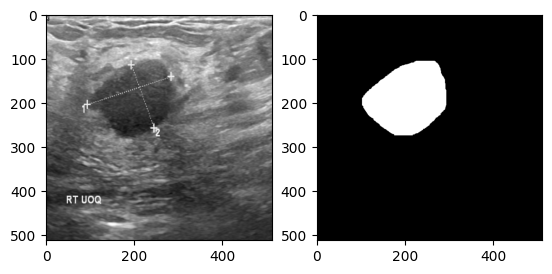

In [41]:
train_dataset = BreastCancerDataset(split="train", transform=train_transform)
val_dataset = BreastCancerDataset(split="val", transform=test_transform)
test_dataset = BreastCancerDataset(split="test", transform=test_transform)

image, mask = train_dataset[random.randint(1, len(train_dataset))]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

## AverageMeter

In [42]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [43]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
    if val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Val Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
    if val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, val_dice_score, 'b', label='Val Dice Score')
        plt.title('Training and Val Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [44]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [45]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [46]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [49]:
def train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    # val_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_batch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_batch*epochs, power=0.9)

    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    val_loss = []
    val_mIoU = []
    val_mDice = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    val_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 5
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        val_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_batch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_batch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=val_loader, colour='yellow')
            
            for image, mask in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                val_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                val_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {val_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", val_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint_data = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU,
                "mDice": mDice
            }
            
            torch.save(checkpoint_data, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint_data, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            val_loss.append(val_loss_meter.avg)
            val_mIoU.append(mIoU)
            val_mDice.append(mDice)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, val_loss, None, val_mIoU, None, val_mDice)


In [50]:
torch.cuda.empty_cache()

import gc
gc.collect()

0

2


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

  0%|          | 0/69 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/40 | Loss 0.4226 | lr 9.77798521260169e-05: 100%|██████████| 69/69 [03:05<00:00,  2.23s/it] /opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/40 | Loss 0.4226 | lr 9.77798521260169e-05: 100%|██████████| 69/69 [03:05<00:00,  2.69s/it]
Val | Loss 0.3357 | mIoU: 0.6022 | dice: 0.7138: 100%|██████████| 15/15 [00:05<00:00,  2.52it/s]


Val | Loss 0.2205 | mIoU: 0.7355 | dice: 0.8284


Train | Epoch 2/40 | Loss 0.1984 | lr 9.552131392330785e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.2692 | mIoU: 0.6193 | dice: 0.7303: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.1326 | mIoU: 0.7482 | dice: 0.8386


Train | Epoch 3/40 | Loss 0.1459 | lr 9.325682592203811e-05: 100%|██████████| 69/69 [03:03<00:00,  2.65s/it]
Val | Loss 0.2298 | mIoU: 0.7799 | dice: 0.8694: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Val | Loss 0.1213 | mIoU: 0.8092 | dice: 0.8861


Train | Epoch 4/40 | Loss 0.1290 | lr 9.098621102391091e-05: 100%|██████████| 69/69 [03:04<00:00,  2.68s/it]
Val | Loss 0.2022 | mIoU: 0.6539 | dice: 0.7650: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.1071 | mIoU: 0.7214 | dice: 0.8159


Train | Epoch 5/40 | Loss 0.1096 | lr 8.870928178587884e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2479 | mIoU: 0.6443 | dice: 0.7555: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0966 | mIoU: 0.7868 | dice: 0.8691


Train | Epoch 6/40 | Loss 0.0983 | lr 8.64258395024974e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it] 
Val | Loss 0.1930 | mIoU: 0.7310 | dice: 0.8318: 100%|██████████| 15/15 [00:05<00:00,  2.59it/s]


Val | Loss 0.0932 | mIoU: 0.7579 | dice: 0.8466


Train | Epoch 7/40 | Loss 0.0971 | lr 8.413567317743088e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.1858 | mIoU: 0.7592 | dice: 0.8535: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0857 | mIoU: 0.7965 | dice: 0.8766


Train | Epoch 8/40 | Loss 0.0837 | lr 8.183855836694984e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2128 | mIoU: 0.7528 | dice: 0.8487: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.0877 | mIoU: 0.8002 | dice: 0.8792


Train | Epoch 9/40 | Loss 0.0840 | lr 7.95342558749754e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it] 
Val | Loss 0.2493 | mIoU: 0.7098 | dice: 0.8143: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0775 | mIoU: 0.8303 | dice: 0.9006


Train | Epoch 10/40 | Loss 0.0746 | lr 7.72225102751984e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it] 
Val | Loss 0.1909 | mIoU: 0.7620 | dice: 0.8555: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0728 | mIoU: 0.8275 | dice: 0.8987


Train | Epoch 11/40 | Loss 0.0683 | lr 7.49030482308113e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.1980 | mIoU: 0.7430 | dice: 0.8410: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.0725 | mIoU: 0.8365 | dice: 0.9048


Train | Epoch 12/40 | Loss 0.0653 | lr 7.257557657617906e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it]
Val | Loss 0.1772 | mIoU: 0.7717 | dice: 0.8627: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.0736 | mIoU: 0.8395 | dice: 0.9069


Train | Epoch 13/40 | Loss 0.0622 | lr 7.023978011698385e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it]
Val | Loss 0.1913 | mIoU: 0.7750 | dice: 0.8649: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.0784 | mIoU: 0.8212 | dice: 0.8942


Train | Epoch 14/40 | Loss 0.0563 | lr 6.789531909553104e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2239 | mIoU: 0.7245 | dice: 0.8263: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.0718 | mIoU: 0.8351 | dice: 0.9038


Train | Epoch 15/40 | Loss 0.0588 | lr 6.554182625536082e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.2450 | mIoU: 0.7108 | dice: 0.8147: 100%|██████████| 15/15 [00:05<00:00,  2.60it/s]


Val | Loss 0.0694 | mIoU: 0.8347 | dice: 0.9036


Train | Epoch 16/40 | Loss 0.0523 | lr 6.317890342319167e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it]
Val | Loss 0.1968 | mIoU: 0.7852 | dice: 0.8724: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0690 | mIoU: 0.8598 | dice: 0.9203


Train | Epoch 17/40 | Loss 0.0531 | lr 6.080611750531918e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2000 | mIoU: 0.7598 | dice: 0.8539: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0667 | mIoU: 0.8689 | dice: 0.9261


Train | Epoch 18/40 | Loss 0.0488 | lr 5.8422995768216605e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it]
Val | Loss 0.1937 | mIoU: 0.7498 | dice: 0.8464: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0745 | mIoU: 0.8562 | dice: 0.9180


Train | Epoch 19/40 | Loss 0.0508 | lr 5.602902023683254e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.1922 | mIoU: 0.7265 | dice: 0.8276: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0683 | mIoU: 0.8638 | dice: 0.9229


Train | Epoch 20/40 | Loss 0.0474 | lr 5.362362099552587e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.1918 | mIoU: 0.7843 | dice: 0.8724: 100%|██████████| 15/15 [00:05<00:00,  2.62it/s]


Val | Loss 0.0752 | mIoU: 0.8591 | dice: 0.9199


Train | Epoch 21/40 | Loss 0.0453 | lr 5.120616811070571e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.1804 | mIoU: 0.7650 | dice: 0.8578: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0703 | mIoU: 0.8504 | dice: 0.9142


Train | Epoch 22/40 | Loss 0.0421 | lr 4.877596180363374e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.1727 | mIoU: 0.7627 | dice: 0.8559: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0743 | mIoU: 0.8430 | dice: 0.9093


Train | Epoch 23/40 | Loss 0.0432 | lr 4.633222037530689e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it] 
Val | Loss 0.1808 | mIoU: 0.7516 | dice: 0.8472: 100%|██████████| 15/15 [00:05<00:00,  2.63it/s]


Val | Loss 0.0750 | mIoU: 0.8427 | dice: 0.9090


Train | Epoch 24/40 | Loss 0.0462 | lr 4.3874065205639255e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]
Val | Loss 0.1829 | mIoU: 0.7680 | dice: 0.8599: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.0783 | mIoU: 0.8511 | dice: 0.9147


Train | Epoch 25/40 | Loss 0.0404 | lr 4.14005018892073e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it]  
Val | Loss 0.2182 | mIoU: 0.7540 | dice: 0.8500: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.0709 | mIoU: 0.8604 | dice: 0.9207


Train | Epoch 26/40 | Loss 0.0397 | lr 3.891039618595279e-05: 100%|██████████| 69/69 [03:04<00:00,  2.67s/it] 
Val | Loss 0.1906 | mIoU: 0.7268 | dice: 0.8286: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0706 | mIoU: 0.8436 | dice: 0.9096


Train | Epoch 27/40 | Loss 0.0372 | lr 3.640244288514375e-05: 100%|██████████| 69/69 [03:03<00:00,  2.66s/it] 
Val | Loss 0.2160 | mIoU: 0.7420 | dice: 0.8407: 100%|██████████| 15/15 [00:05<00:00,  2.61it/s]


Val | Loss 0.0732 | mIoU: 0.8466 | dice: 0.9117


Train | Epoch 28/40 | Loss 0.0364 | lr 3.387512478116071e-05: 100%|██████████| 69/69 [03:03<00:00,  2.67s/it] 
Val | Loss 0.2089 | mIoU: 0.7574 | dice: 0.8527: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.0722 | mIoU: 0.8561 | dice: 0.9179
Early stopping!


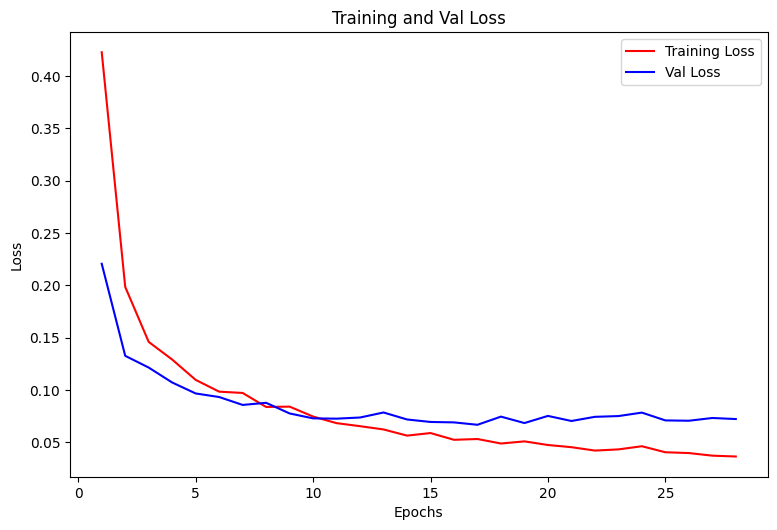

In [51]:
num_class = 1
n_workers = int(os.cpu_count() / 2)
print(n_workers)
batch_size = 8
lr = 1e-4
epochs = 40
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(train_dataset, val_dataset, num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

## Inference

In [52]:
def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    # Load validation dataset
    
    images, orig_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for i in idx:
            ori_img, orig_mask = test_dataset[i]
            img = ori_img

            # Predict mask
            img = img.float().to(device).unsqueeze(0)
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long().cpu().numpy()

            images.append(unNorm(ori_img).permute(1, 2, 0))
            orig_masks.append(orig_mask)
            pred_masks.append(pred_mask)

    
    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)
    
    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()



indexs = [46, 86, 87, 18, 31, 82, 79, 56]




/tmp/ipykernel_30/10437291.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth)


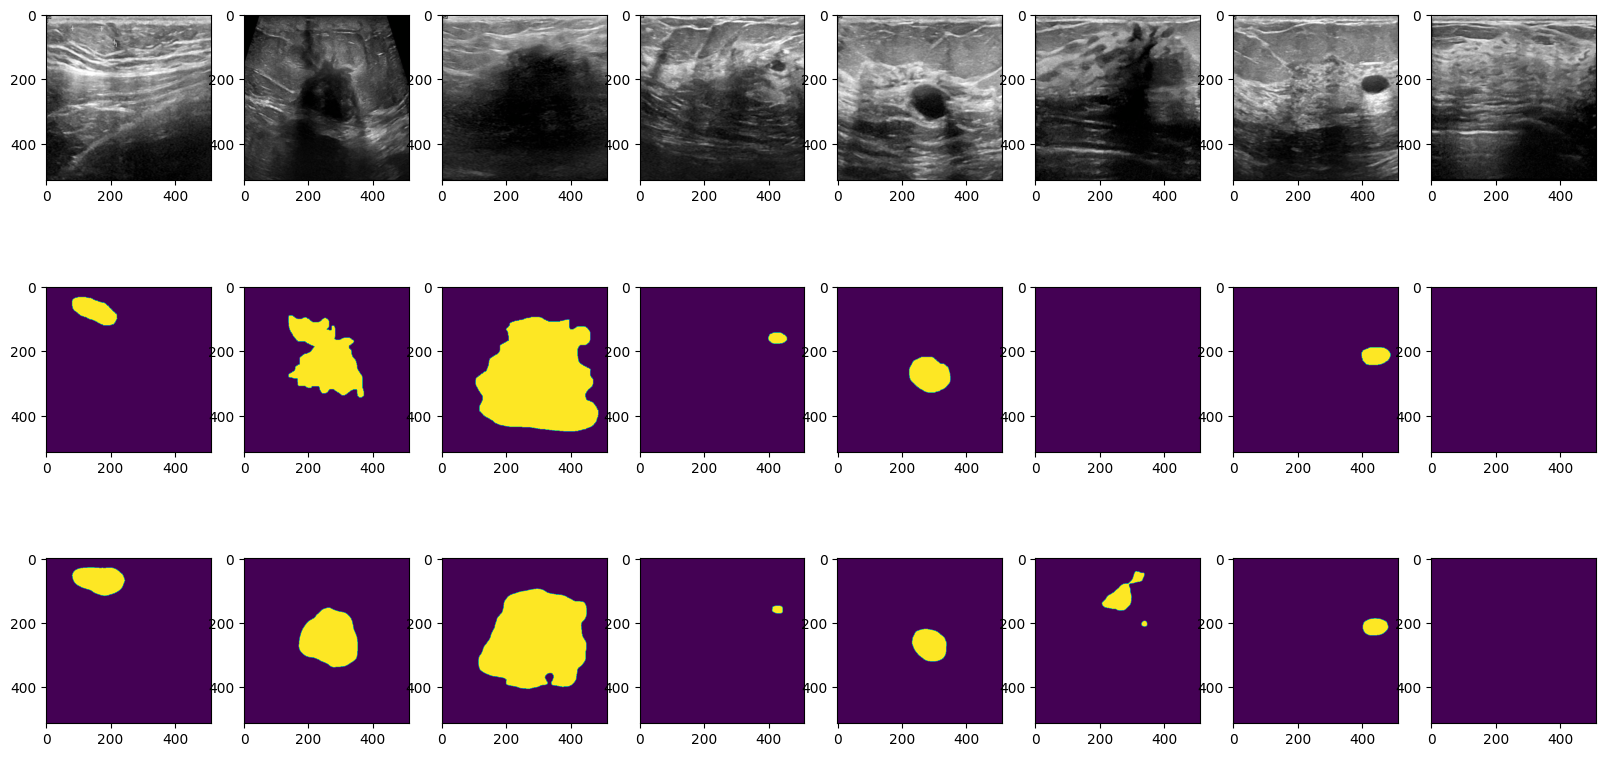

In [53]:
import random
#Note: You must train the model before using this param
model_pth = "/kaggle/working/saved_model/best.pt"
print("\n")
indexs = random.sample(range(len(test_dataset)), 8)
print("indexs =", indexs)
print("\n")

#Show images
pred_show_image_grid(model_pth, device, test_dataset, num_class, indexs, num_imgs= 8)